# Try computing an independent priming probability plot for each timepoint 
- Spike in lymphoid for CS10-11
# current Solve for fate probabilities towards all terminal states
- use a cricular projection of the data
- try subsetting by stage at end

# We try using a background organ-state to increase the resolution of rarelineages

In [1]:
import sys
import subprocess

%matplotlib inline
from collections import Counter
from collections import defaultdict
import scanpy as sc
import pandas as pd
import pickle as pkl
import numpy as np
import scipy
import matplotlib.pyplot as plt
import re
import glob
import os
import sys
from numpy import cov
import scipy.cluster.hierarchy as spc
import seaborn as sns; sns.set(color_codes=True)
from sklearn.linear_model import LogisticRegression
import sklearn
from pathlib import Path
from matplotlib import rcParams
rcParams['figure.figsize'] = 10,60

import scvelo as scv
import scanpy as sc
import cellrank as cr
import numpy as np

scv.settings.verbosity = 3
scv.settings.set_figure_params("scvelo")
cr.settings.verbosity = 2

In [42]:
adata_ref = sc.read('/nfs/team205/ig7/work_backups/backup_210306/projects/YS/YS_030522_notebooks/Submission_figure_scripts/F3/HSPC_comparison_dotplots/A2_V9_SCVI_V10_HAEM_lineages_subset_YS.h5ad')

In [43]:
#adata = sc.read('/lustre/scratch117/cellgen/team298/SharedFolders/YS_proj/Datasets/temp_combined_YS_EL_no_obsm_raw_20220520.h5ad')

In [44]:
adata = sc.read('/nfs/team205/ig7/work_backups/backup_210306/projects/YS/YS_030522_notebooks/Submission_figure_scripts/F1/EL_YS_combined_scvi/A2_V8_YS_EL_build_scvi_220522_10_20.h5ad')

#### For combined object
- Artifically subsample the liver data to 20% of each population
- Artificially define terminal states
- Fix this in post to adress oversample/undersampling issue

# Create stage mapper

In [45]:
stages = [
'CS10',
'CS11',
'CS14',
'CS15',
'CS17',
'CS18',
'CS22',
'CS23',]
stage_groups = [
'CS10_11',
'CS10_11',
'CS14_15',
'CS14_15',
'CS17_18',
'CS17_18',
'CS22_23',
'CS22_23',]
stage_groups_order = [
'CS10_11',
'CS14_15',
'CS17_18',
'CS22_23',]
stage_mapper = dict(zip(stages,stage_groups))
adata.obs['stage_groups'] = adata.obs['stage'].astype(str).map(stage_mapper)
adata.obs['stage_groups'] = adata.obs['stage_groups'].astype('category').cat.reorder_categories(stage_groups_order)

# Update YS annots

In [51]:
adata.obs['broad_cell.labels'] = adata.obs['broad_cell.labels'].str.replace('Progenitors','Progenitor')
keep_cell_states= [
'Endoderm',
 'Erythroid',
 'Macrophage',
 'MK',
 'Mast_cell',
 'Monocyte',
 'DC',
 'Granulocyte_precursors',
 'Lymphoid',
 'Microglia',
 'Progenitor',
 'Kupffer_cell',
 'Granulocyte_precursor',
 'B_lymphoid']
adata = adata[adata.obs['broad_cell.labels'].isin(keep_cell_states)]

In [52]:
list(adata.obs['broad_cell.labels'].unique())

['Progenitor',
 'Erythroid',
 'Endoderm',
 'Macrophage',
 'MK',
 'Mast_cell',
 'Monocyte',
 'DC',
 'Granulocyte_precursors',
 'Lymphoid',
 'Microglia',
 'Kupffer_cell',
 'Granulocyte_precursor',
 'B_lymphoid']

In [58]:
adata.obs.groupby('stage_groups').apply(len)

stage_groups
CS10_11     8970
CS14_15    26890
CS17_18    89791
CS22_23     3195
dtype: int64

In [59]:
adata.obs.groupby(['cell_labels_lvl3']).apply(len)

cell_labels_lvl3
CMP                          25
Cycling DC2                  81
DEF_HSPC_1                  241
DEF_HSPC_2                  387
Early_Erythroid             699
Eo_Baso_Mast_precursor       56
Eo_Basophil                  93
Erythroid                 61038
ILC_precursor               185
LMPP                        169
Lymphoid B lin              152
Lymphoid_progenitor         605
MEMP                        762
MK                         2044
MOP                         211
Mac DC2                      60
Macrophage                44413
Mast_cell                   354
Microglia                   613
Mid_Erythroid               638
Mono Mac DC2                 99
Mono Mac pre DC2             68
Monocyte_0                  200
Monocyte_Macrophage          63
Monocyte_ys_1               176
NK                          170
Neutrophil_precursor         51
PRIM_HSPC_1                1880
PRIM_HSPC_2                 560
Pre DC2                     238
Pre_Macrophage         

# Slice by stage?

In [61]:
map_state = ['PRIM_HSPC','DEF_HSPC']
stage = 'CS10_11' #'CS10_11'

# adata = adata_orig.copy()
# adata.obsm['to_terminal_states'] = g_fwd.absorption_probabilities

# #####################

# # Compute KDE for pim HSPC
# sc.tl.embedding_density(adata, basis='umap', groupby='cell_labels_lvl_lineage', key_added='umap_density_dataset_annot', components=None)
# for i in map_state:
#     adata.obs['umap_density_dataset_annot_'+i] = adata.obs['umap_density_dataset_annot']
#     adata.obs.loc[~adata.obs['cell_labels_lvl_lineage'].isin([i]),('umap_density_dataset_annot_'+i)] = 0.1
    
# #####################

# Slice to only contain age group
keep = list(adata.obs.index[adata.obs['stage_groups'].isin([stage])])
keep = keep + list(adata.obs.index[adata.obs['tissue'].isin(['Liver'])])
keep = keep + list(adata.obs.index[adata.obs['cell_labels_lvl3'].isin(['Pre_Macrophage'])])
# keep = keep + (list(adata.obs.index[adata.obs['cell_labels_lvl_mixed'].isin(['Lymphoid'])]))
# keep.append(list(adata.obs.index[adata.obs['cell_labels_lvl_lineage'].isin(['Lymphoid'])]))
adata = adata[adata.obs.index.isin(keep)]


# Create a common lioneage category

In [68]:
adata_backup = adata.copy()

In [70]:
adata.obs.loc[adata.obs['tissue'].isin(['Liver']),'cell_labels_lvl_mixed'] = adata.obs.loc[adata.obs['tissue'].isin(['Liver']),'broad_cell.labels']
adata.obs.loc[adata.obs['cell_labels_lvl3'].isin(['Pre_Macrophage']),'cell_labels_lvl_mixed'] = 'Pre_Macrophage'
adata.obs['cell_labels_lvl_lineage'] = adata.obs['cell_labels_lvl_mixed'].astype(str).copy()

<ipython-input-70-dbf0d51e16cc>:3: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['cell_labels_lvl_lineage'] = adata.obs['cell_labels_lvl_mixed'].astype(str).copy()


In [73]:
adata.obs['cell_labels_lvl_lineage'] = adata.obs['cell_labels_lvl_mixed'].astype(str).copy()
mix = ['PRIM_HSPC_1',
 'Erythroid',
 'Macrophage',
 'PRIM_HSPC_2',
 'MK',
 'Lymphoid_progenitor',
 'Mast_cell',
 'DEF_HSPC_2',
 'Monocyte',
 'MEMP',
 'DEF_HSPC_1',
 'DC',
 'Granulocyte_precursors',
 'MOP',
 'Lymphoid',
 'CMP',
 'Kupffer_cell',
 'Progenitor',
 'B_lymphoid',
 'Granulocyte_precursor',
'Pre_Macrophage']

lin = [
'PRIM_HSPC',
 'Erythroid',
 'Macrophage',
 'PRIM_HSPC',
 'MK',
 'Lymphoid_progenitor',
 'Mast_cell',
 'DEF_HSPC',
 'Myeloid',
 'Progenitor',
 'DEF_HSPC',
 'DC',
 'Granulocyte_precursors',
 'Progenitor',
 'Lymphoid',
 'Progenitor',
 'Macrophage',
 'Progenitor',
 'Lymphoid',
 'Granulocyte_precursors',
 'Myeloid',
]
mapper = dict(zip(mix,lin))
adata.obs['cell_labels_lvl_lineage'] = adata.obs['cell_labels_lvl_lineage'].map(mapper)
adata.obs['cell_labels_lvl_lineage'] = adata.obs['cell_labels_lvl_lineage'].astype('category')

In [1]:
sc.pp.neighbors(adata, n_neighbors=20, n_pcs=15,use_rep = 'X_scvi',copy=False)
sc.tl.umap(adata)
sc.tl.draw_graph(adata, layout='fa')

In [78]:
adata.write('./' + stage + 'test_subsample_haem_ys_EL.h5ad')

This detected 5000 highly variable genes. 
computing neighbors
    finished (0:00:05) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:03) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
Computing CytoTRACE score with `5000` genes. Consider using more than `10000` genes
Adding `adata.obs['ct_score']`
       `adata.obs['ct_pseudotime']`
       `adata.obs['ct_num_exp_genes']`
       `adata.var['ct_gene_corr']`
       `adata.var['ct_correlates']`
       `adata.uns['ct_params']`
    Finish (0:00:00)
Computing transition matrix based on `ct_pseudotime`



    Finish (0:00:11)
Projecting transition matrix onto `draw_graph_fa`
Adding `adata.obsm['T_fwd_draw_graph_fa']`
    Finish (0:00:06)


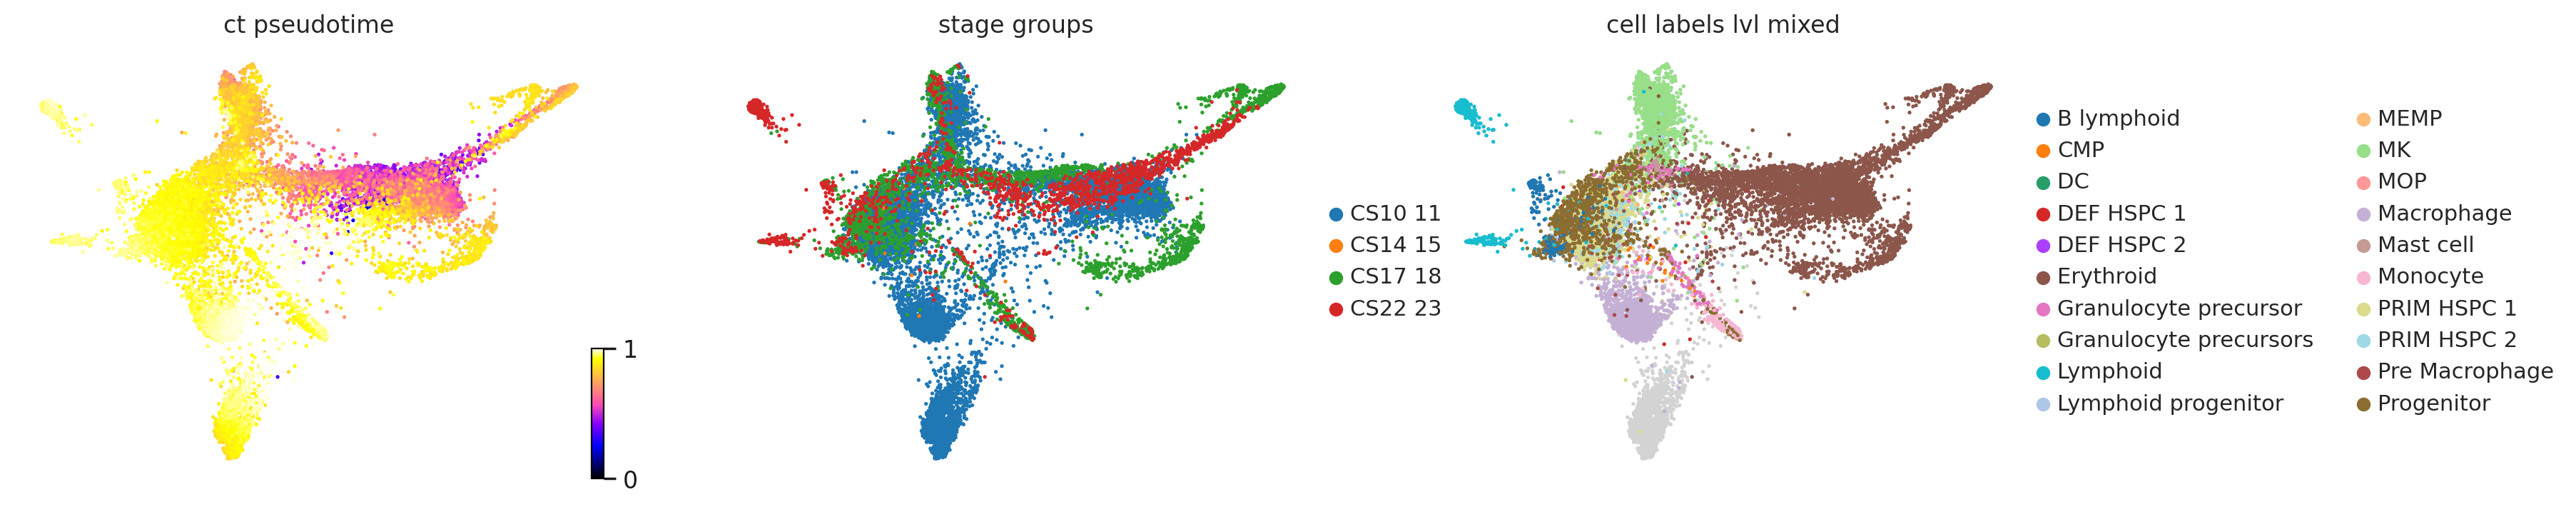

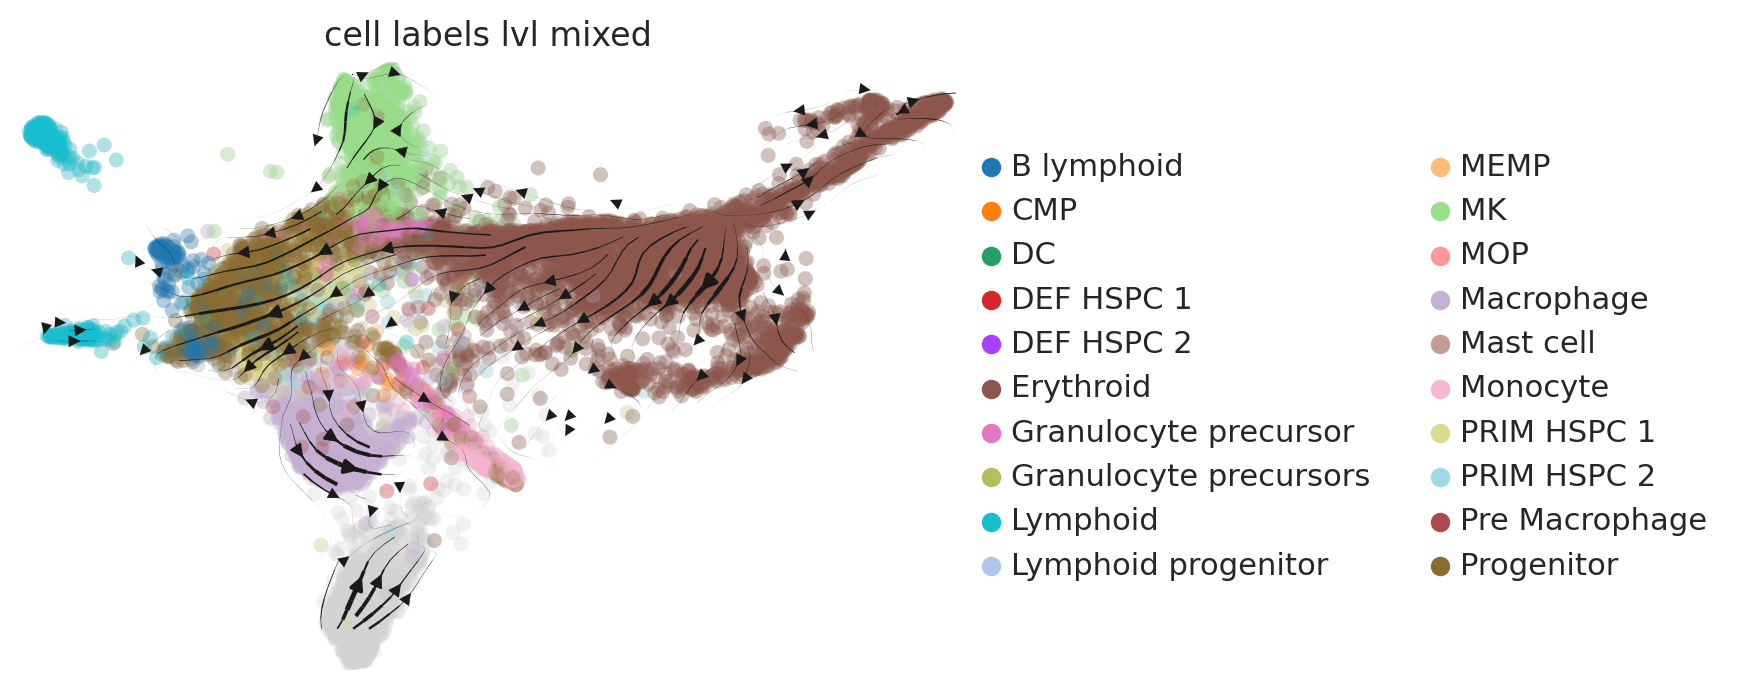

In [84]:
adata.var['highly_variable']=True

print(f"This detected {np.sum(adata.var['highly_variable'])} highly variable genes. ")
# use scVelo's `moments` function for imputation - note that hack we're using here:
# we're copying our `.X` matrix into the layers because that's where `scv.tl.moments`
# expects to find counts for imputation
adata.layers["spliced"] = adata.X
adata.layers["unspliced"] = adata.X
scv.pp.moments(adata, n_pcs=20, n_neighbors=30,use_rep='X_scvi')

##########################################################################

from cellrank.tl.kernels import CytoTRACEKernel
ctk = CytoTRACEKernel(adata)
ctk.compute_transition_matrix(threshold_scheme="soft", nu=0.5)
ctk.compute_projection(basis="draw_graph_fa")

scv.pl.scatter(
adata,
c=["ct_pseudotime", "stage_groups","cell_labels_lvl_mixed"],
basis="draw_graph_fa",
legend_loc="right",
color_map="gnuplot2"
)
scv.pl.velocity_embedding_stream(
adata, color="cell_labels_lvl_mixed", vkey="T_fwd", basis="draw_graph_fa", legend_loc="right"
)

GPCCA[n=13234, kernel=<CytoTRACEKernel[dnorm=False, scheme=soft, b=10.0, nu=0.5]>]
Computing Schur decomposition
Mat Object: 1 MPI processes
  type: seqdense
9.9999999999999378e-01 2.2637902643142622e-04 1.1622453340069804e-03 4.6673091092185905e-04 1.4375443463125735e-03 -2.6621828149451928e-03 7.3424443844709647e-03 -4.9332469572299165e-04 -9.6879049628739201e-03 1.4789278444565715e-02 2.0687306265515441e-03 1.4276344712221136e-02 -5.6362557473412771e-03 -2.3727244725668464e-03 -1.8235393245192383e-02 
0.0000000000000000e+00 9.9593490136060348e-01 -1.4731025960701720e-04 1.9541699846893618e-04 1.0310684259011869e-04 3.8941247004581331e-04 3.2974997429706377e-04 -4.0741433444790675e-04 -9.7188727003236669e-05 1.0554135848002643e-03 -6.1738003079189069e-04 -3.8551773733803119e-03 1.1245317714938799e-02 1.3735240933267097e-03 -4.1821003250993522e-03 
0.0000000000000000e+00 0.0000000000000000e+00 9.9562999638722494e-01 4.2350362829390631e-04 1.4139663497957704e-04 -5.7706374912396018e-04

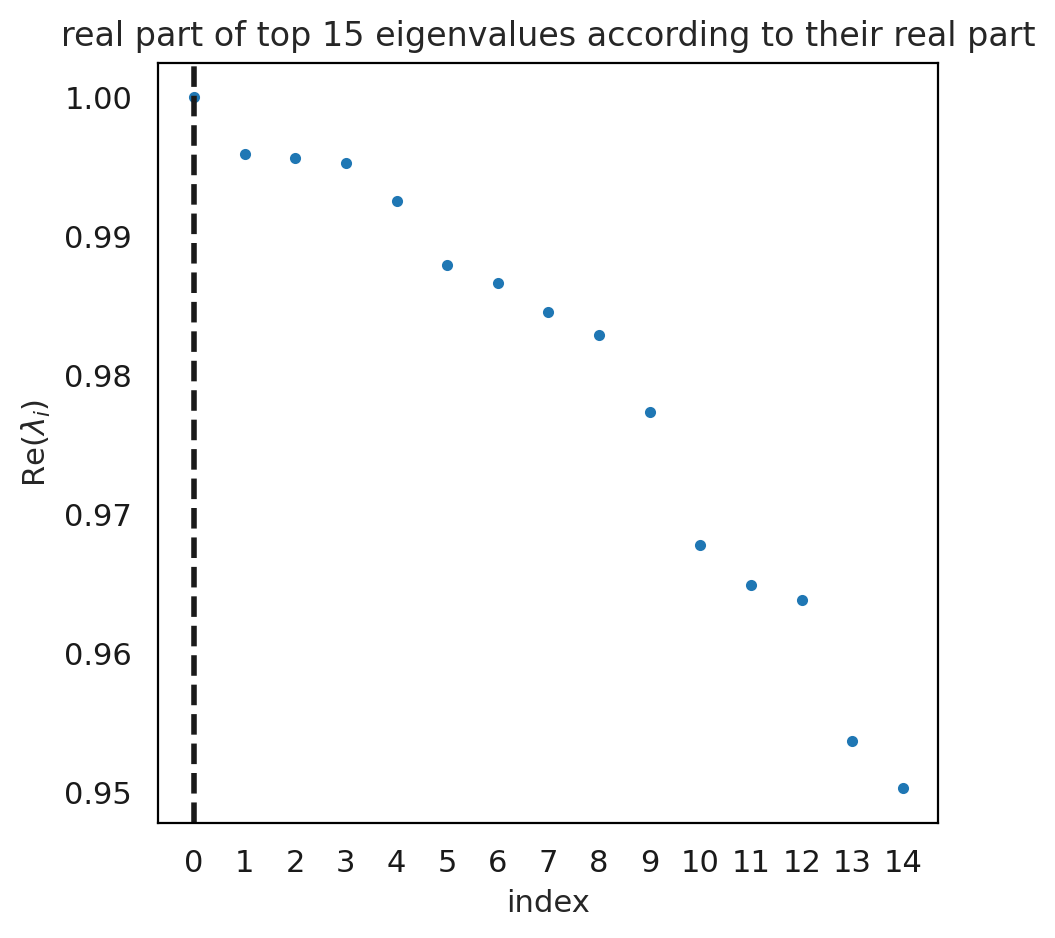

In [86]:
from cellrank.tl.estimators import GPCCA
g_fwd = GPCCA(ctk)
print(g_fwd)
g_fwd.compute_schur(n_components=15, method= 'krylov') #method='brandts is true schur distribution but will not scale
g_fwd.plot_spectrum(real_only=True)

Adding `adata.obs['terminal_states']`
       `adata.obs['terminal_states_probs']`
       `.terminal_states`
       `.terminal_states_probabilities`
       `.terminal_states_memberships
    Finish`


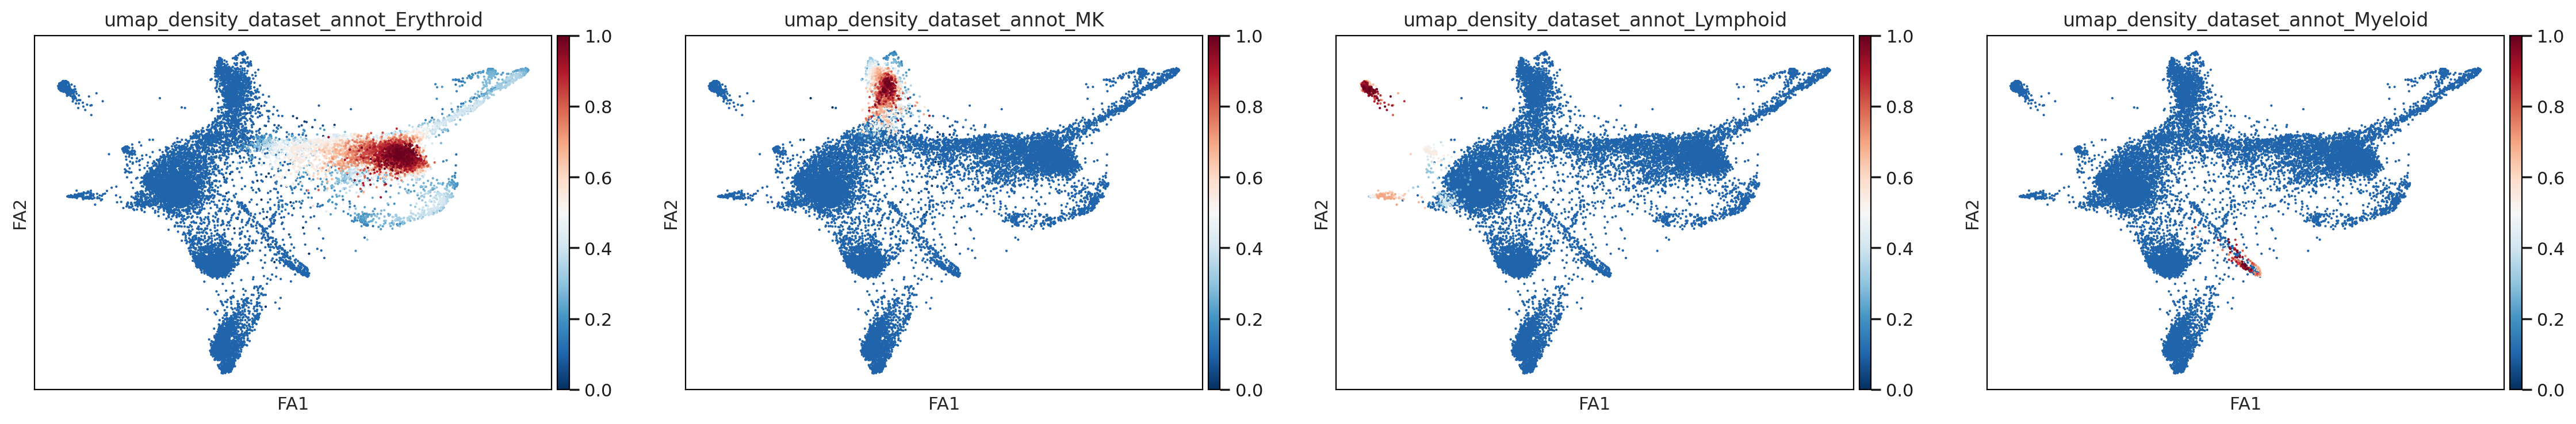

In [56]:
var_group = 'cell_labels_lvl_lineage'
sc.tl.embedding_density(adata, basis='umap', groupby=var_group, key_added='umap_density_dataset_annot', components=None)
macro = {}
state_init = [
'Erythroid',    
'MK',
'Lymphoid',
'Myeloid',
]
densities = []
for i in state_init:
    # find KDE center of density for each state
    adata.obs['umap_density_dataset_annot_'+i] = adata.obs['umap_density_dataset_annot']
    adata.obs.loc[~adata.obs[var_group].isin([i]),('umap_density_dataset_annot_'+i)] = 0.1
    macro[i] =adata.obs.index[adata.obs.index.isin(adata.obs['umap_density_dataset_annot_'+i].nlargest(30).index)]
    densities.append('umap_density_dataset_annot_'+i)
    #macro[i] = adata[adata.obs["cell_labels_lvl_lineage"] == i].obs_names
g_fwd.set_terminal_states(macro)
sc.pl.draw_graph(adata,color = densities)

In [100]:
adata = adata_orig.copy()

In [101]:
g_fwd_orig = g_fwd.copy()
adata_pre_split = adata.copy()

In [248]:
map_state = ['PRIM_HSPC','DEF_HSPC']

####################

# Compute KDE for pim HSPC
sc.tl.embedding_density(adata, basis='umap', groupby='cell_labels_lvl_lineage', key_added='umap_density_dataset_annot', components=None)
for i in map_state:
    adata.obs['umap_density_dataset_annot_'+i] = adata.obs['umap_density_dataset_annot']
    adata.obs.loc[~adata.obs['cell_labels_lvl_lineage'].isin([i]),('umap_density_dataset_annot_'+i)] = 0.1
    
map_state = ['Progenitor']

####################

# Compute KDE for pim HSPC
sc.tl.embedding_density(adata, basis='umap', groupby='broad_cell.labels', key_added='umap_density_dataset_annot', components=None)
for i in map_state:
    adata.obs['umap_density_dataset_annot_'+i] = adata.obs['umap_density_dataset_annot']
    adata.obs.loc[~adata.obs['cell_labels_lvl_lineage'].isin([i]),('umap_density_dataset_annot_'+i)] = 0.1

### Informally, given a (finite, discrete) Markov chain with a set of transient states  and a set of absorbing states , the absorption probability for cell  from  to reach cell  from  is the probability that a random walk initialized in  ### will reach absorbing state .

### In our context, states correspond to cells, in particular, absorbing states correspond to cells in terminal states.

In [251]:
term_state_probs = g_fwd.absorption_probabilities.copy()

/home/jovyan/my-conda-envs/workhorse/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [252]:
adata.obsm['to_terminal_states'] = g_fwd.absorption_probabilities

In [ ]:
map_state = ['PRIM_HSPC','DEF_HSPC']
stage = 'CS10_11' #'CS10_11'
organ = ['YS']

adata = adata_orig.copy()
adata.obsm['to_terminal_states'] = g_fwd.absorption_probabilities

#####################

# Compute KDE for pim HSPC
sc.tl.embedding_density(adata, basis='umap', groupby='cell_labels_lvl_lineage', key_added='umap_density_dataset_annot', components=None)
for i in map_state:
    adata.obs['umap_density_dataset_annot_'+i] = adata.obs['umap_density_dataset_annot']
    adata.obs.loc[~adata.obs['cell_labels_lvl_lineage'].isin([i]),('umap_density_dataset_annot_'+i)] = 0.1
map_state = ['Progenitor']

####################

# Compute KDE for prim HSPC
sc.tl.embedding_density(adata, basis='umap', groupby='broad_cell.labels', key_added='umap_density_dataset_annot', components=None)
for i in map_state:
    adata.obs['umap_density_dataset_annot_'+i] = adata.obs['umap_density_dataset_annot']
    adata.obs.loc[~adata.obs['broad_cell.labels'].isin([i]),('umap_density_dataset_annot_'+i)] = 0.1    
    
# Slice to only contain age group
keep = list(adata.obs.index[adata.obs['stage_groups'].isin([stage])])
adata = adata[adata.obs.index.isin(keep)]
adata = adata[adata.obs['tissue'].isin(organ)]

cr.pl.circular_projection(adata, keys=['umap_density_dataset_annot_DEF_HSPC','umap_density_dataset_annot_PRIM_HSPC','umap_density_dataset_annot', "cell_labels_lvl_lineage"], lineages = state_init,legend_loc="right", title="",early_cells={'cell_labels_lvl_lineage':'PRIM_HSPC'}, lineage_order='default', metric='correlation', normalize_by_mean=True,save = stage,cmap = 'RdBu_r' ,size = 10)

In [62]:
g_fwd.absorption_probabilities

In [255]:
state_init = [  
'MK',  
'Erythroid',  
'Lymphoid',
 'Myeloid',
]

/home/jovyan/my-conda-envs/workhorse/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Create custom sizing map

In [256]:
list(adata.obs['cell_labels_lvl_lineage'].unique())

['PRIM_HSPC',
 'Erythroid',
 nan,
 'Macrophage',
 'MK',
 'Lymphoid_progenitor',
 'Mast_cell',
 'DEF_HSPC',
 'Myeloid',
 'Progenitor',
 'DC',
 'Granulocyte_precursors',
 'Lymphoid']

In [257]:
# Compute KDE for pim HSPC
sc.tl.embedding_density(adata, basis='umap', groupby='cell_labels_lvl_lineage', key_added='umap_density_dataset_annot', components=None)
for i in map_state:
    adata.obs['umap_density_dataset_annot_'+i] = adata.obs['umap_density_dataset_annot']
    adata.obs.loc[~adata.obs['cell_labels_lvl_lineage'].isin([i]),('umap_density_dataset_annot_'+i)] = 0.1

In [258]:
adata.obs.groupby(['cell_labels_lvl_lineage']).apply(len)

cell_labels_lvl_lineage
DC                           5
DEF_HSPC                    55
Erythroid                 2417
Granulocyte_precursors       9
Lymphoid                     3
Lymphoid_progenitor         15
MK                        1095
Macrophage                1488
Mast_cell                    4
Myeloid                     15
PRIM_HSPC                 2293
Progenitor                  56
dtype: int64

In [259]:
adata.obs.groupby(['cell_labels_lvl_lineage','cell_labels_lvl3']).apply(len)

cell_labels_lvl_lineage  cell_labels_lvl3      
DC                       Mono Mac pre DC2             1
                         Pre DC2                      4
DEF_HSPC                 DEF_HSPC_1                  40
                         DEF_HSPC_2                  15
Erythroid                Early_Erythroid            421
                         Erythroid                 1995
                         Mid_Erythroid                1
Granulocyte_precursors   Eo_Baso_Mast_precursor       5
                         Neutrophil_precursor         4
Lymphoid                 Lymphoid B lin               2
                         NK                           1
Lymphoid_progenitor      Lymphoid_progenitor         15
MK                       MK                        1095
Macrophage               Macrophage                1488
Mast_cell                Mast_cell                    4
Myeloid                  Monocyte_0                   3
                         Monocyte_ys_1                3


In [260]:
adata.obs.loc[adata.obs['cell_labels_lvl3'].isin(['CMP','MEMP']),'cell_labels_lvl_lineage'] = 'PRIM_HSPC'

In [261]:
# Compute KDE for pim HSPC
sc.tl.embedding_density(adata, basis='umap', groupby='cell_labels_lvl_lineage', key_added='umap_density_dataset_annot', components=None)
for i in map_state:
    adata.obs['umap_density_dataset_annot_'+i] = adata.obs['umap_density_dataset_annot']
    adata.obs.loc[~adata.obs['cell_labels_lvl_lineage'].isin([i]),('umap_density_dataset_annot_'+i)] = 0.1

In [262]:
map_state = ['PRIM_HSPC']

adata.obs['sizes'] =  30
for i in map_state:
    adata.obs.loc[adata.obs['cell_labels_lvl_lineage'].isin([i]),'sizes'] = (adata.obs.loc[adata.obs['cell_labels_lvl_lineage'].isin([i]),'umap_density_dataset_annot_DEF_HSPC']*600).round(0)

/home/jovyan/my-conda-envs/workhorse/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


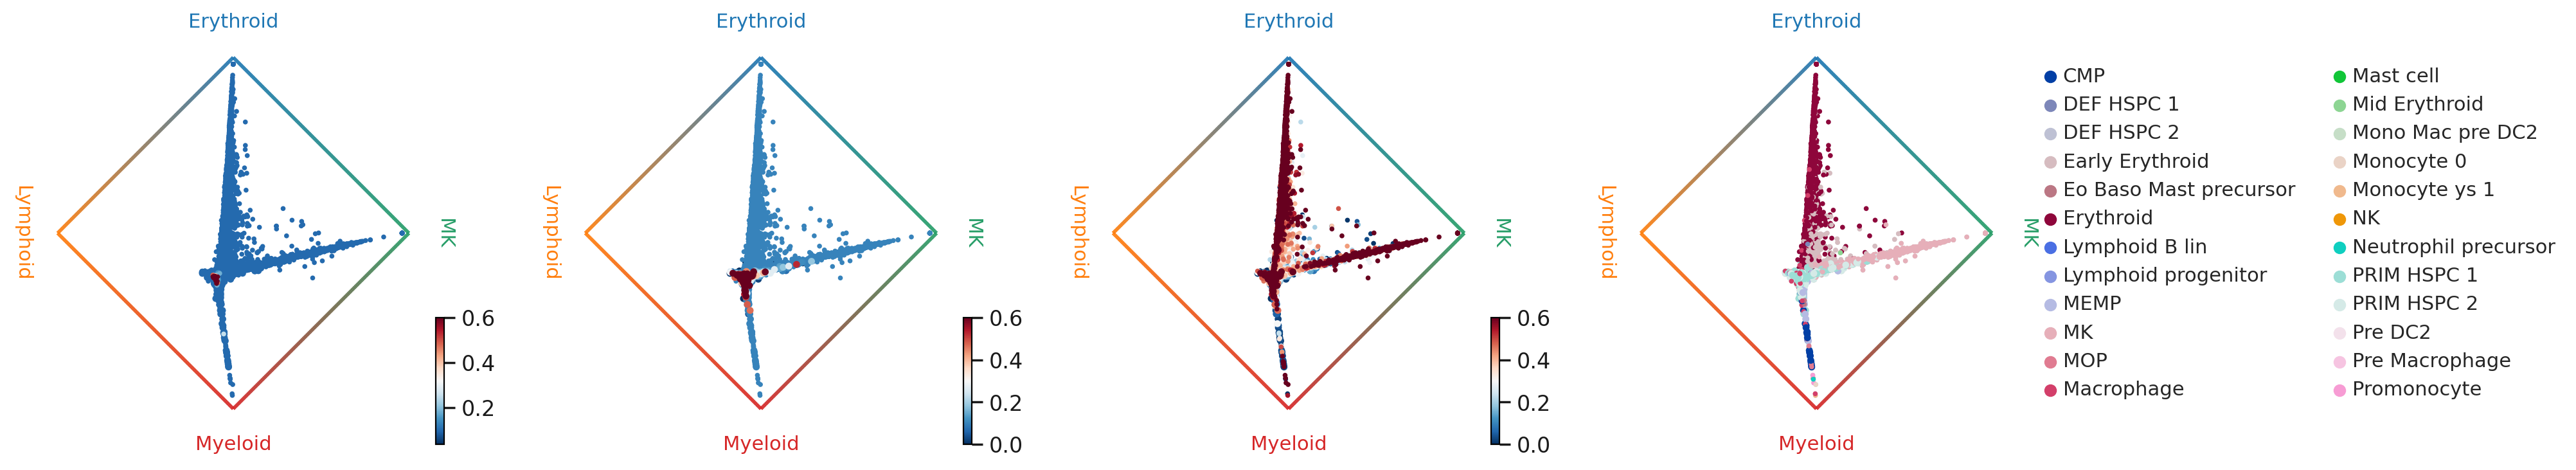

In [268]:
cr.pl.circular_projection(adata, keys=['umap_density_dataset_annot_DEF_HSPC','umap_density_dataset_annot_PRIM_HSPC','umap_density_dataset_annot', "cell_labels_lvl3"], lineages = state_init,legend_loc="right", title="",early_cells={'cell_labels_lvl_lineage':'PRIM_HSPC'}, lineage_order='default', metric='correlation', normalize_by_mean=True,save = stage,cmap = 'RdBu_r' ,size =np.array(adata.obs['sizes']),vmax = 0.6)

In [ ]:
keys=['umap_density_dataset_annot_DEF_HSPC','umap_density_dataset_annot_PRIM_HSPC','umap_density_dataset_annot', "cell_labels_lvl_lineage"], lineages = state_init,legend_loc="right", title="",early_cells={'cell_labels_lvl_lineage':'PRIM_HSPC'}, lineage_order='default', metric='correlation', normalize_by_mean=True,save = stage,cmap = 'RdBu_r' ,size = 10)

In [184]:
g_fwd.write('./pre_AGM_YS_HSPC_lineage_priming_potentials', write_adata=True, ext='pickle')

# Plot for main fig

In [2]:
g_fwd = cr.tl.estimators.GPCCA.read('/nfs/team205/ig7/work_backups/backup_210306/projects/YS/YS_030522_notebooks/Submission_figure_scripts/F3/HSPC_comparison_dotplots/transition_state_prob_overtime_YS/pre_AGM_YS_HSPC_lineage_priming_potentials.pickle')

In [3]:
adata = g_fwd.adata

Adding `adata.obs['terminal_states']`
       `adata.obs['terminal_states_probs']`
       `.terminal_states`
       `.terminal_states_probabilities`
       `.terminal_states_memberships
    Finish`


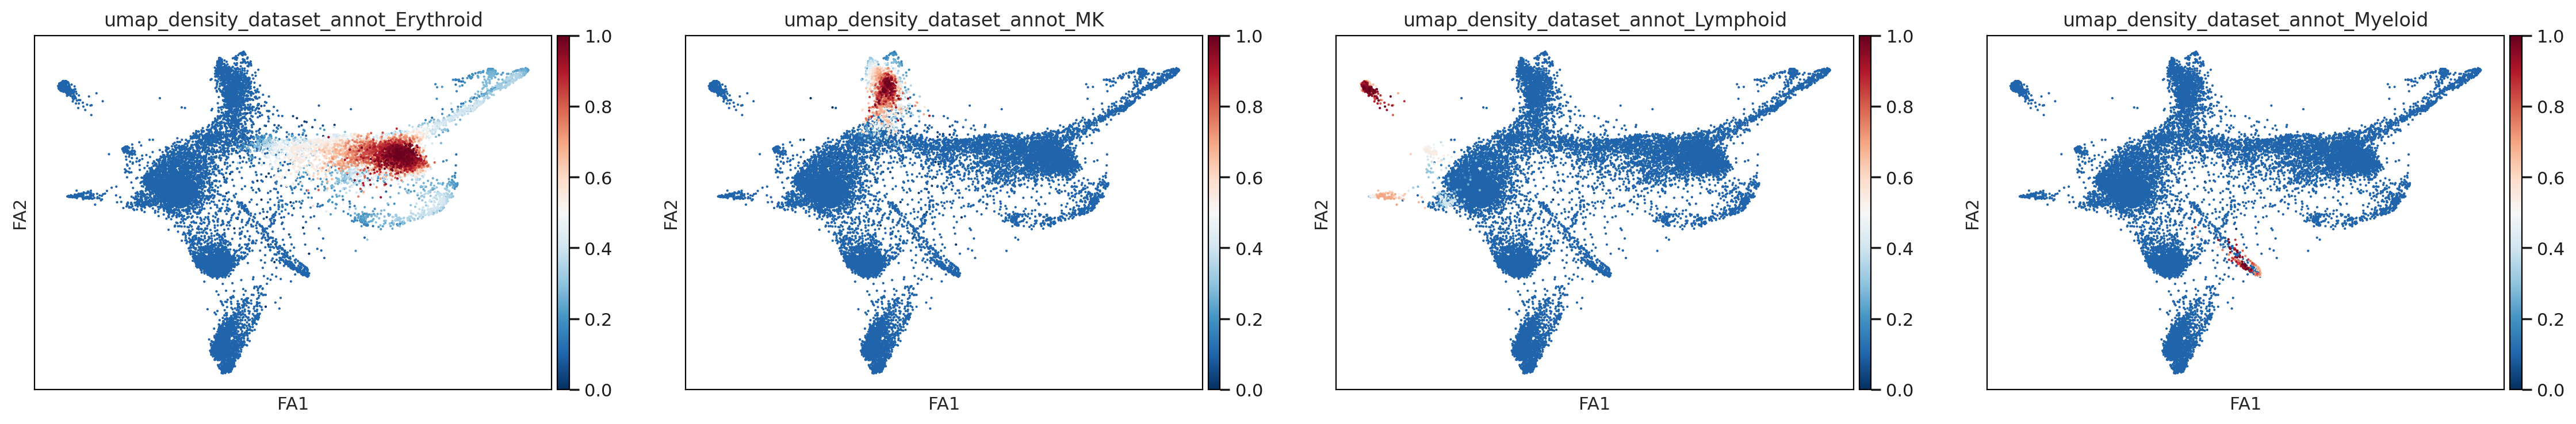

In [4]:
var_group = 'cell_labels_lvl_lineage'
sc.tl.embedding_density(adata, basis='umap', groupby=var_group, key_added='umap_density_dataset_annot', components=None)
macro = {}
state_init = [
'Erythroid',    
'MK',
'Lymphoid',
'Myeloid',
]
densities = []
for i in state_init:
    # find KDE center of density for each state
    adata.obs['umap_density_dataset_annot_'+i] = adata.obs['umap_density_dataset_annot']
    adata.obs.loc[~adata.obs[var_group].isin([i]),('umap_density_dataset_annot_'+i)] = 0.1
    macro[i] =adata.obs.index[adata.obs.index.isin(adata.obs['umap_density_dataset_annot_'+i].nlargest(30).index)]
    densities.append('umap_density_dataset_annot_'+i)
    #macro[i] = adata[adata.obs["cell_labels_lvl_lineage"] == i].obs_names
g_fwd.set_terminal_states(macro)
sc.pl.draw_graph(adata,color = densities)

In [5]:
map_state = ['PRIM_HSPC','DEF_HSPC']

####################

# Compute KDE for pim HSPC
sc.tl.embedding_density(adata, basis='umap', groupby='cell_labels_lvl_lineage', key_added='umap_density_dataset_annot', components=None)
for i in map_state:
    adata.obs['umap_density_dataset_annot_'+i] = adata.obs['umap_density_dataset_annot']
    adata.obs.loc[~adata.obs['cell_labels_lvl_lineage'].isin([i]),('umap_density_dataset_annot_'+i)] = 0.1
    
map_state = ['Progenitor']

####################

# Compute KDE for pim HSPC
sc.tl.embedding_density(adata, basis='umap', groupby='broad_cell.labels', key_added='umap_density_dataset_annot', components=None)
for i in map_state:
    adata.obs['umap_density_dataset_annot_'+i] = adata.obs['umap_density_dataset_annot']
    adata.obs.loc[~adata.obs['cell_labels_lvl_lineage'].isin([i]),('umap_density_dataset_annot_'+i)] = 0.1

Computing absorption probabilities



Adding `adata.obsm['to_terminal_states']`
       `.absorption_probabilities`
    Finish (0:00:01)


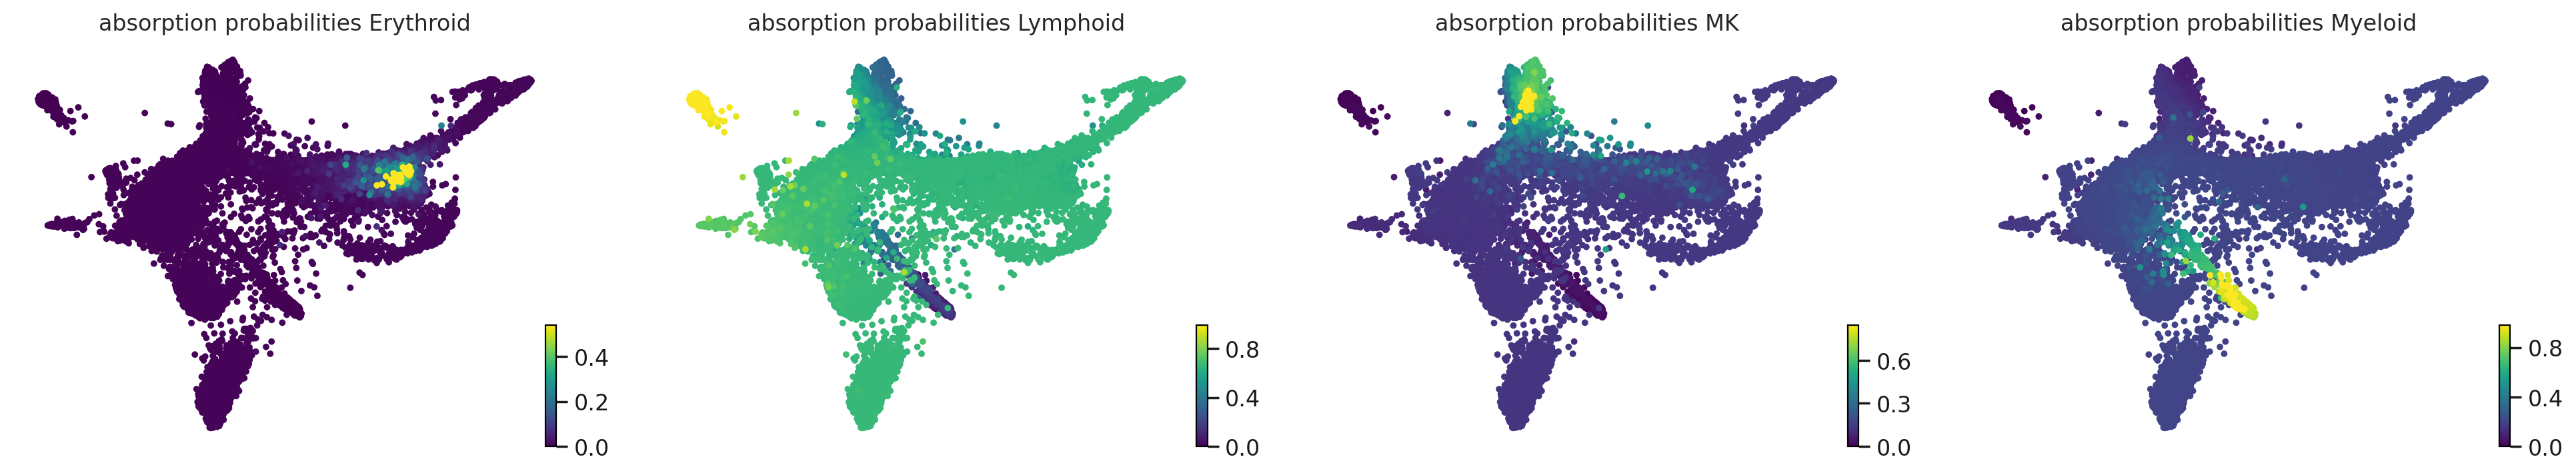

In [6]:
# states = states_inc 
#g_fwd.compute_macrostates(n_states=10, cluster_key="cell_labels_lvl_lineage")
#g_fwd.set_terminal_states_from_macrostates(names=states)
g_fwd.compute_absorption_probabilities()#solver='direct'
g_fwd.plot_absorption_probabilities(same_plot=False, size=50, basis="draw_graph_fa")
adata.obsm['to_terminal_states'] = g_fwd.absorption_probabilities

In [7]:
# remove DEF
adata = adata[~adata.obs['cell_labels_lvl_lineage'].isin(['DEF_HSPC'])]

map_state = ['PRIM_HSPC','DEF_HSPC']
stage = 'CS10_11' #'CS10_11'
organ = ['YS']

# adata = adata_orig.copy()
#adata.obsm['to_terminal_states'] = g_fwd.absorption_probabilities.copy()

#####################

# Compute KDE for pim HSPC
sc.tl.embedding_density(adata, basis='umap', groupby='cell_labels_lvl_lineage', key_added='umap_density_dataset_annot', components=None)
for i in map_state:
    adata.obs['umap_density_dataset_annot_'+i] = adata.obs['umap_density_dataset_annot']
    adata.obs.loc[~adata.obs['cell_labels_lvl_lineage'].isin([i]),('umap_density_dataset_annot_'+i)] = 0.1
    
map_state = ['Progenitor']

####################

# Compute KDE for prim HSPC
sc.tl.embedding_density(adata, basis='umap', groupby='broad_cell.labels', key_added='umap_density_dataset_annot', components=None)
for i in map_state:
    adata.obs['umap_density_dataset_annot_'+i] = adata.obs['umap_density_dataset_annot']
    adata.obs.loc[~adata.obs['broad_cell.labels'].isin([i]),('umap_density_dataset_annot_'+i)] = 0.1    

# Slice to only contain age group
keep = list(adata.obs.index[adata.obs['stage_groups'].isin([stage])])
adata = adata[adata.obs.index.isin(keep)]
adata = adata[adata.obs['tissue'].isin(organ)]

/home/jovyan/my-conda-envs/workhorse/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/home/jovyan/my-conda-envs/workhorse/lib/python3.8/site-packages/scanpy/tools/_embedding_density.py:169: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[density_covariate] = density_values


In [8]:
state_init = [  
'MK',
'Erythroid',  
'Lymphoid',
 'Myeloid',
]

In [9]:
adata.obs['lineage_2'] = adata.obs['cell_labels_lvl_lineage'].copy()
adata.obs.loc[adata.obs['cell_labels_lvl3'].isin(['Pre_Macrophage']),'lineage_2'] = 'PRIM_HSPC'

<ipython-input-9-f935a3652eb9>:1: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['lineage_2'] = adata.obs['cell_labels_lvl_lineage'].copy()


In [10]:
map_state = ['PRIM_HSPC','DEF_HSPC']

####################

# Compute KDE for pim HSPC
sc.tl.embedding_density(adata, basis='umap', groupby='lineage_2', key_added='umap_density_dataset_annot', components=None)
for i in map_state:
    adata.obs['umap_density_dataset_annot_'+i] = adata.obs['umap_density_dataset_annot']
    adata.obs.loc[~adata.obs['lineage_2'].isin([i]),('umap_density_dataset_annot_'+i)] = 0.1
    adata.obs.loc[adata.obs['lineage_2'].isin([i]),('umap_density_dataset_annot_'+i)] = adata.obs.loc[adata.obs['lineage_2'].isin([i]),('umap_density_dataset_annot_'+i)]+0.3

/home/jovyan/my-conda-envs/workhorse/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


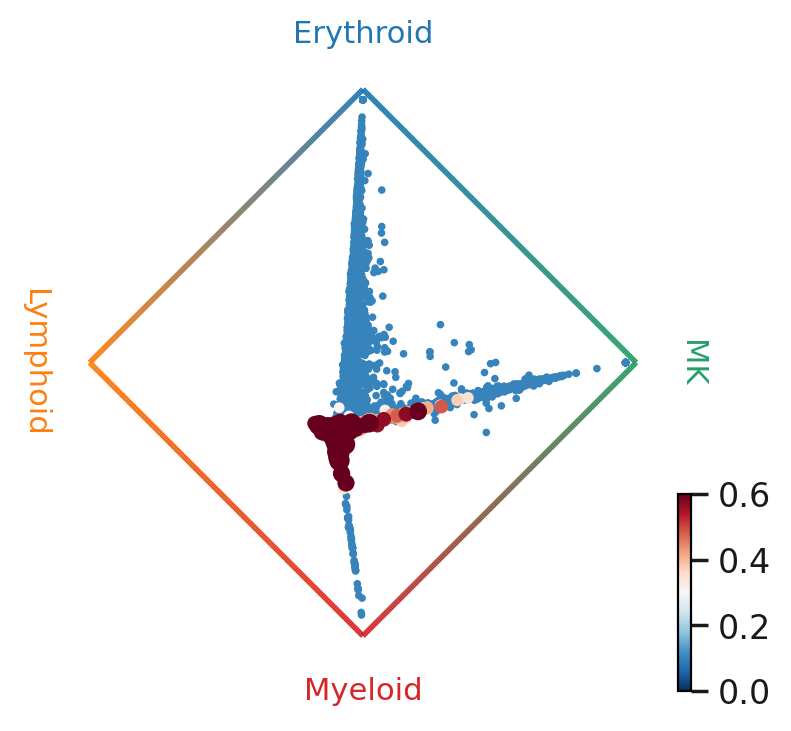

In [13]:
map_state = ['PRIM_HSPC']

adata.obs['sizes'] =  30
for i in map_state:
    adata.obs.loc[adata.obs['lineage_2'].isin([i]),'sizes'] = (adata.obs.loc[adata.obs['lineage_2'].isin([i]),'umap_density_dataset_annot_PRIM_HSPC']*200).round(0)
#    adata.obs.loc[adata.obs['lineage_2'].isin([i]),'sizes'] = (adata.obs.loc[adata.obs['lineage_2'].isin([i]),'umap_density_dataset_annot_DEF_HSPC']*100).round(0)
cr.pl.circular_projection(adata, keys=['umap_density_dataset_annot_PRIM_HSPC'], lineages = state_init,legend_loc="right", title="",early_cells={'cell_labels_lvl_lineage':'PRIM_HSPC'}, lineage_order='default', metric='correlation', normalize_by_mean=True,save = 'Pre_AGM_V2_PRIM.pdf',cmap = 'RdBu_r' ,size =np.array(adata.obs['sizes']),vmax = 0.6,vmin = 0)

In [107]:
map_state = ['DEF_HSPC']

####################

# Compute KDE for pim HSPC
sc.tl.embedding_density(adata, basis='umap', groupby='lineage_2', key_added='umap_density_dataset_annot', components=None)
for i in map_state:
    adata.obs['umap_density_dataset_annot_'+i] = adata.obs['umap_density_dataset_annot']
    adata.obs.loc[~adata.obs['lineage_2'].isin([i]),('umap_density_dataset_annot_'+i)] = 0.1
#    adata.obs.loc[adata.obs['lineage_2'].isin([i]),('umap_density_dataset_annot_'+i)] = adata.obs.loc[adata.obs['lineage_2'].isin([i]),('umap_density_dataset_annot_'+i)]+0.3

/home/jovyan/my-conda-envs/workhorse/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


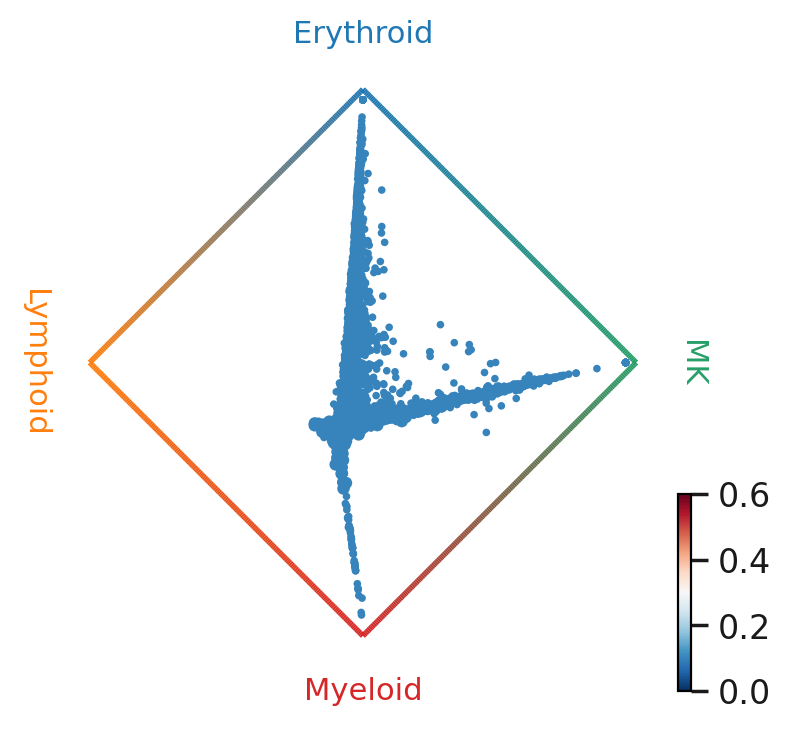

In [109]:
cr.pl.circular_projection(adata, keys=['umap_density_dataset_annot_DEF_HSPC'], lineages = state_init,legend_loc="right", title="",early_cells={'cell_labels_lvl_lineage':'DEF_HSPC'}, lineage_order='default', metric='correlation', normalize_by_mean=True,save = 'Pre_AGM_V2_DEF.pdf',cmap = 'RdBu_r' ,size =np.array(adata.obs['sizes']),vmax = 0.6,vmin = 0)

/home/jovyan/my-conda-envs/workhorse/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


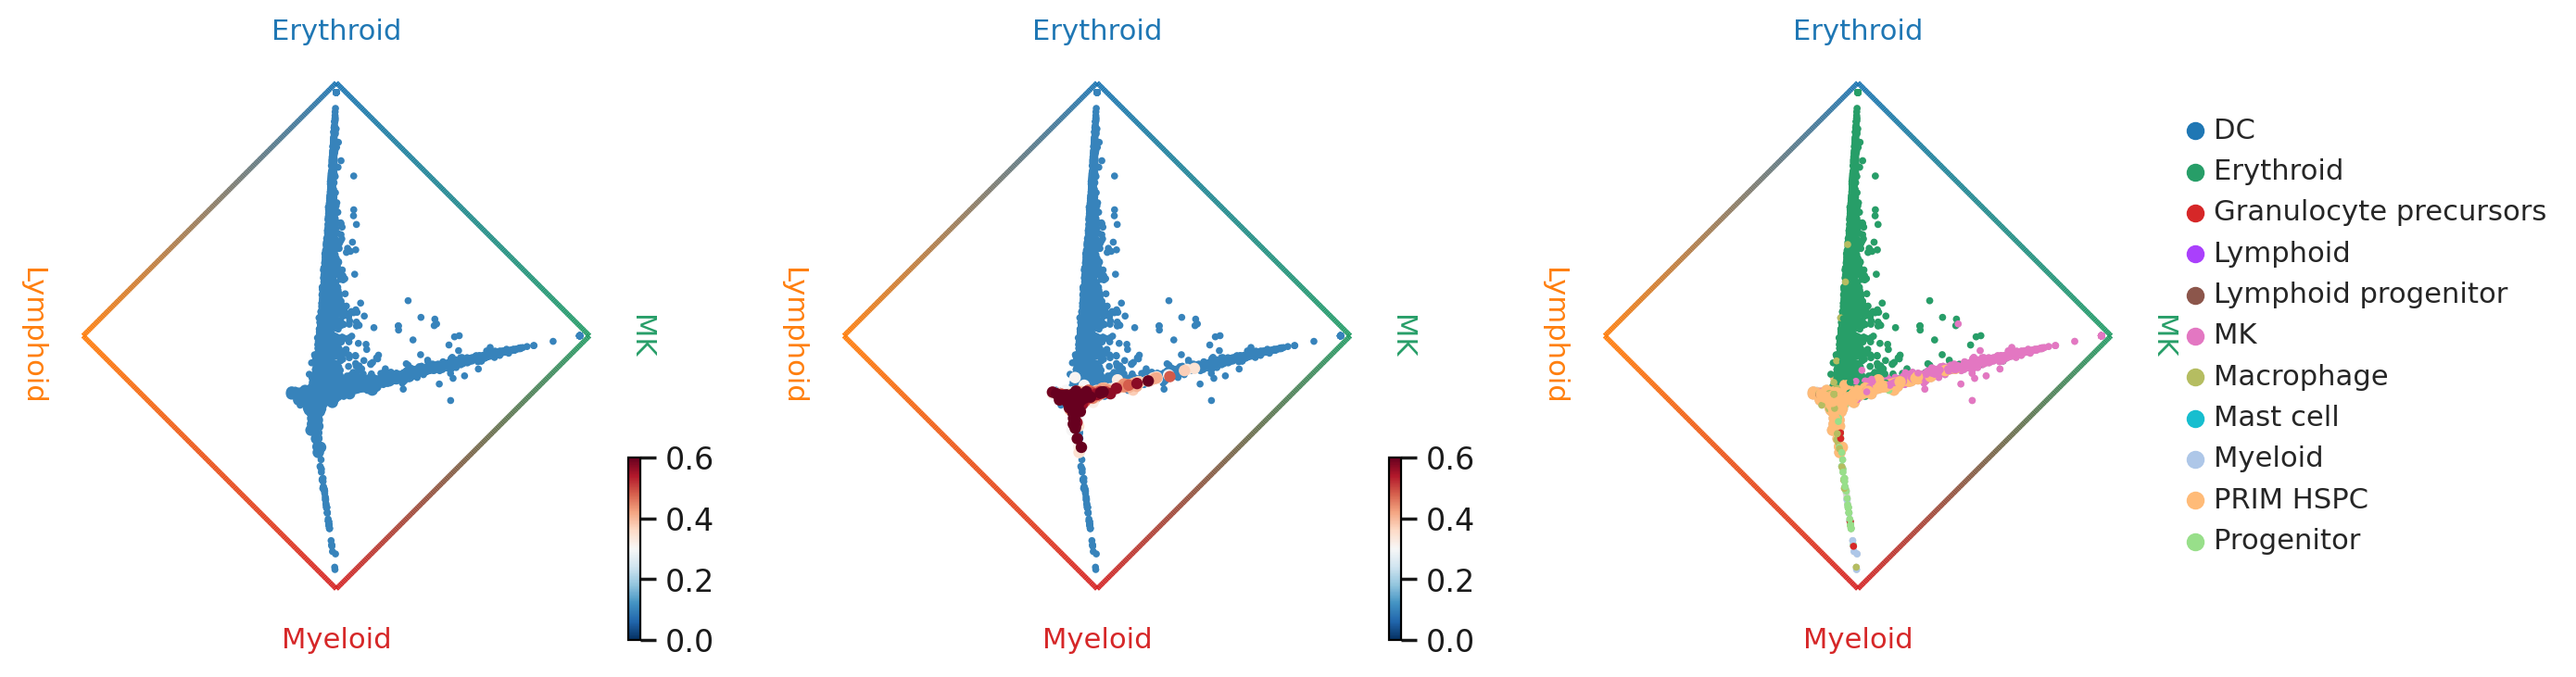

In [114]:
cr.pl.circular_projection(adata, keys=['umap_density_dataset_annot_DEF_HSPC','umap_density_dataset_annot_PRIM_HSPC', "cell_labels_lvl_lineage"], lineages = state_init,legend_loc="right", title="",early_cells={'cell_labels_lvl_lineage':'PRIM_HSPC'}, lineage_order='default', metric='correlation', normalize_by_mean=True,save = 'Pre_AGM_V3.pdf',cmap = 'RdBu_r' ,size =np.array(adata.obs['sizes']),vmax = 0.6,vmin=0)

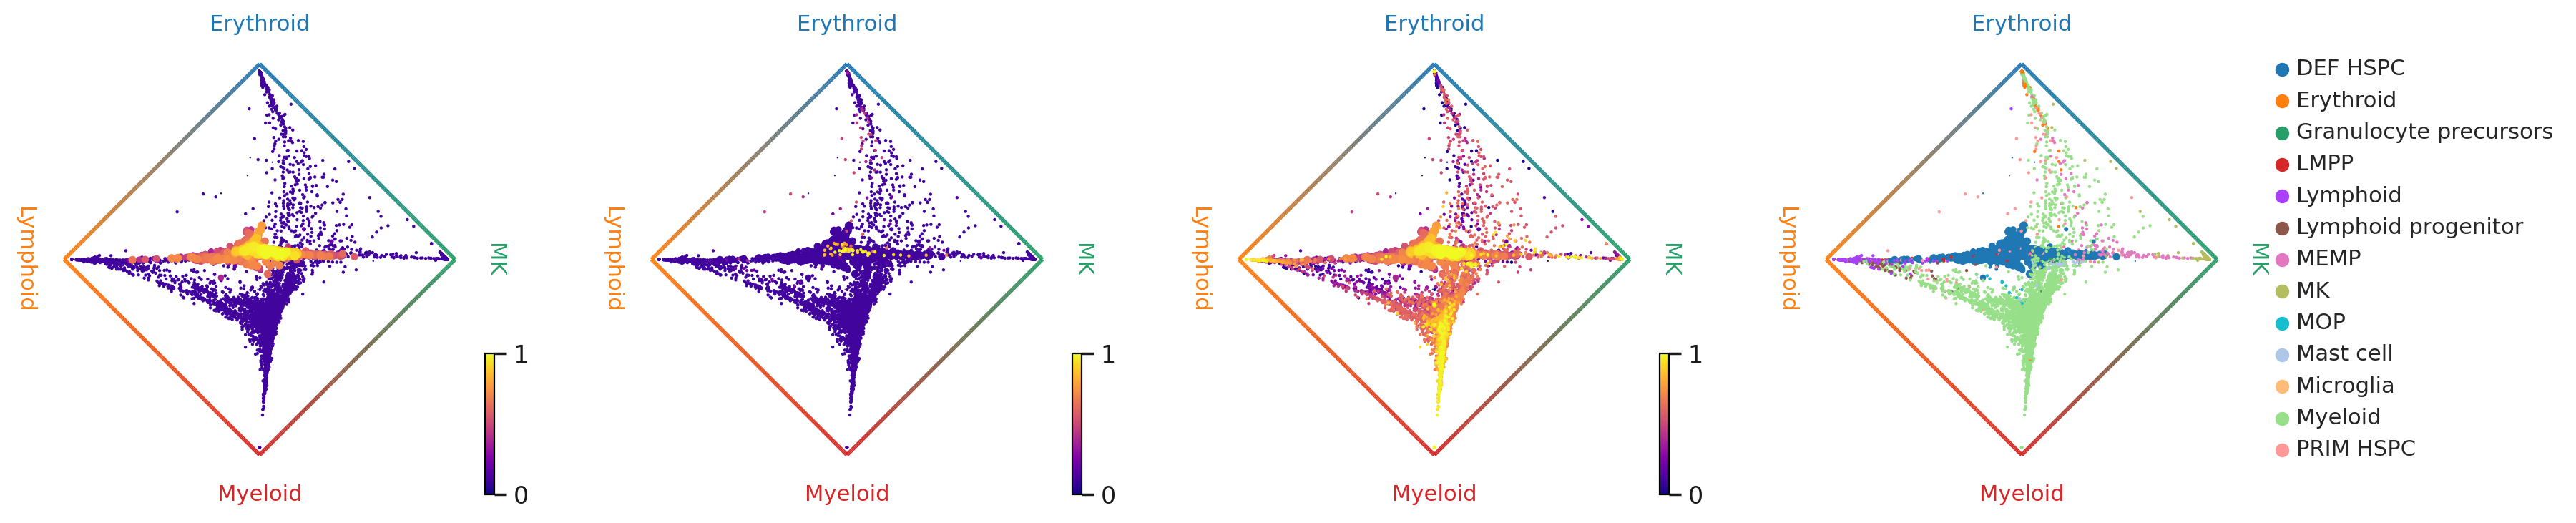

In [9]:
cr.pl.circular_projection(adata, keys=['umap_density_dataset_annot_DEF_HSPC','umap_density_dataset_annot_PRIM_HSPC','umap_density_dataset_annot', "cell_labels_lvl_lineage"], lineages = state_init,legend_loc="right", title="",early_cells={'cell_labels_lvl_lineage':'PRIM_HSPC'}, lineage_order='default', metric='correlation', normalize_by_mean=True,save = 'Post_AGM_V2',cmap = 'plasma' ,size =np.array(adata.obs['sizes']))

In [83]:
adata.obs['stage_float'] = adata.obs['stage'].str.replace('CS','')

/home/jovyan/my-conda-envs/workhorse/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [84]:
adata.obs['stage_float']

Wang_et_al_AAACCTGCACTTAAGC_1-0    10
Wang_et_al_AAACCTGGTAACGACG_1-0    10
Wang_et_al_AAACCTGGTCAAAGAT_1-0    10
Wang_et_al_AAACCTGGTCCGAAGA_1-0    10
Wang_et_al_AAACCTGGTCCGCTGA_1-0    10
                                   ..
Wang_et_al_TTTGTCAAGTACCGGA_2-0    11
Wang_et_al_TTTGTCAAGTGTGAAT_2-0    11
Wang_et_al_TTTGTCACATCGGGTC_2-0    11
Wang_et_al_TTTGTCACATCGTCGG_2-0    11
Wang_et_al_TTTGTCAGTCAATGTC_2-0    11
Name: stage_float, Length: 8950, dtype: object

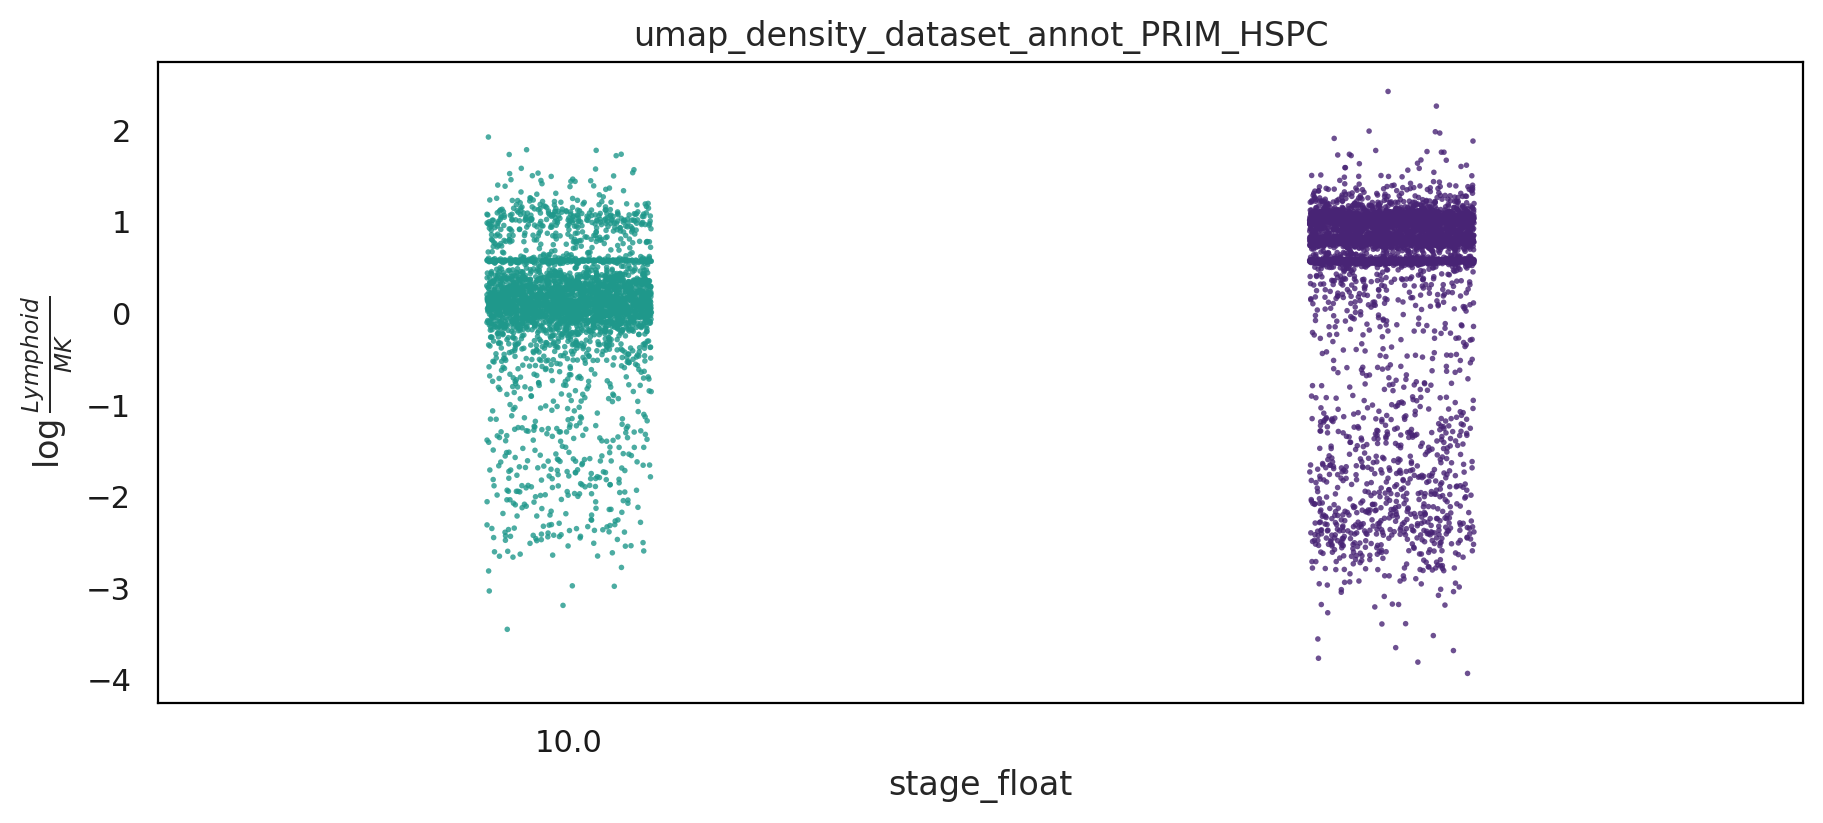

In [85]:
cr.pl.log_odds(
    adata,
    lineage_1="Lymphoid",
    lineage_2="MK",
    time_key="stage_float",
    keys=["umap_density_dataset_annot_PRIM_HSPC"],
    threshold=0,
    size=2,
    xticks_step_size=4,
    figsize=(9, 4),
    legend_loc="upper right out",
)